<a href="https://colab.research.google.com/github/vladi29/ANA-Classifier/blob/main/4_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Universidad Simon Bolivar - 26 de Enero de 2022
# Trabajo final de grado: Clasificador de patrones ANA
# Vladimir Alfaro - 1510023

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import time
import h5py

device = "cuda" if torch.cuda.is_available() else "cpu"

# Cleaning the VRAM memory
#torch.cuda.empty_cache()
#torch.cuda.reset_peak_memory_stats(device=None)
#print("Espacio disponible en GPU (Gb): ", torch.cuda.memory_allocated()*1e-9)

In [18]:
# Paths

images_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Augmented_dataset/'
labels_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/labels.csv'
names_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/names.csv'
dataset_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Augmented_dataset.h5'

names = pd.read_csv(names_path, header = None)
names = names.values.tolist()

labels_raw = pd.read_csv(labels_path, header = None)
labels_raw = labels_raw.values.tolist()
total_labels = []
for label in labels_raw:
  total_labels.append(label[0])


torch.FloatTensor
Negativos:  2905 
Nuclear:  6840 
Citoplasmaticos:  3380 
Mitotico:  805
Pesos de cada clase:  tensor([0.1697, 0.0721, 0.1458, 0.6124])


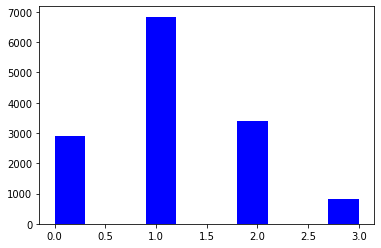


Etiquetas divididas para cada muestra:  [['FewNuclearDots', 'NUMA-1MSA-1'], ['FewNuclearDots', 'NUMA-1MSA-1'], ['FewNuclearDots', 'NUMA-1MSA-1'], ['FewNuclearDots', 'NUMA-1MSA-1'], ['FewNuclearDots', 'NUMA-1MSA-1'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['CoarseSpeckled', 'CytoplasmicReticularAMA'], ['CoarseSpeckled', 'CytoplasmicReticularAMA'], ['CoarseSpeckled', 'CytoplasmicReticularAMA'], ['CoarseSpeckled', 'CytoplasmicReticularAMA'], ['CoarseSpeckled', 'CytoplasmicReticularAMA'], ['NuclearMembranous', 'FineSpeckled'], ['NuclearMembranous', 'FineSpeckled'], ['NuclearMembranous', 'FineSpeckled'], ['NuclearMembranous', 'FineSpeckled'], ['NuclearMembranous', 'FineSpeckled'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['NucleolarHomogeneous'], ['NucleolarHomogeneous'], ['NucleolarHomogeneous'], ['NucleolarHomogeneous'], ['NucleolarHomogeneous'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['Cytoplasmic

In [19]:
# Preparacion de las etiquetas para cada imagen

split_labels = []
basic_level_labels_raw = []
basic_level_labels = []
basic_level_labels_to_model = []

for label in total_labels: # Separamos las etiquetas para cada muestra
  split_labels.append(label.split("_"))

for label in split_labels:
  group = []
  for basic_label in label:
    if (basic_label == "NuclearHomogeneous" or basic_label == "DSF-70" or basic_label == "Centromere" or 
        basic_label == "FineSpeckled" or basic_label == "CoarseSpeckled" or basic_label == "MultipleNuclearDots" or
        basic_label == "FewNuclearDots" or basic_label == "NucleolarHomogeneous" or basic_label == "NucleolarClumpy" or
        basic_label == "NucleolarSpeckled" or basic_label == "NuclearMembranous" or basic_label == "NuclearMembranepores" or
        basic_label == "PCNA" or basic_label == "PCNA(ProliferatingCellNuclearAntigen)" or basic_label == "SCl-70"):  # Hay algunas imagenes con la etiqueta PCNA(ProliferatingCellNuclearAntigen)
      group.append(1)
    elif (basic_label == "CytoplasmicSpeckled" or basic_label == "CytolplasmicSpeckled" or basic_label == "CytoplasmicFibrillar" or # Hay algunas imagenes con la etiqueta CytolplasmicSpeckled
          basic_label == "CytoplasmicReticularAMA" or basic_label == "CytoplasmicPolarGolgiLike" or basic_label == "Tubulin"):
      group.append(2)
    elif (basic_label == "Centriole" or basic_label == "NUMA-1MSA-1" or basic_label == "Midbody(MSA-2)"):
      group.append(3)
    elif (basic_label == "Negative"):
      group.append(0)
    else:
      print("LOS QUE FALTAN: ", basic_label)
  basic_level_labels_raw.append(group)

for group in basic_level_labels_raw:
  basic_level_labels.append(list(set(group)))

for group in basic_level_labels:
  total_label_group = [0, 0, 0, 0]
  for clase in group:
    total_label_group[clase] = 1
  basic_level_labels_to_model.append(total_label_group)

Negatives = 0
Nuclear = 0
Cytoplasmic = 0
Mitotic = 0
weights, histogram_data = [], []

for labels in basic_level_labels_to_model:  
  if labels[0] == 1:
    Negatives += 1
    histogram_data.append(0)
  if labels[1] == 1:
    Nuclear += 1
    histogram_data.append(1)
  if labels[2] == 1:
    Cytoplasmic += 1
    histogram_data.append(2)
  if labels[3] == 1:
    Mitotic += 1
    histogram_data.append(3)

# Creacion de un vector de pesos para balancear las clases
weights.append(Negatives)
weights.append(Nuclear)
weights.append(Cytoplasmic)
weights.append(Mitotic)
weights = np.array(weights)
weights = 1/weights
weights = weights/np.sum(weights)
weights = torch.tensor(weights, dtype=torch.float)
print(weights.type())

print("Negativos: ", Negatives, "\nNuclear: ", Nuclear,
      "\nCitoplasmaticos: ", Cytoplasmic, "\nMitotico: ", Mitotic)
print("Pesos de cada clase: ", weights)
plt.hist(histogram_data, facecolor = 'blue', alpha = 1)
plt.show()

print("\nEtiquetas divididas para cada muestra: ", split_labels)
print("Etiquetas traducidas a los 4 grandes grupos: ", basic_level_labels_raw)
print("Etiquetas traducidas a los 4 grandes grupos (sin valores repetidos): ", basic_level_labels)

print("\nEtiquetas finales para el modelo: ", basic_level_labels_to_model)
print("Tamano de arreglo de etiquetas finales: ", len(basic_level_labels_to_model))

# Division de la data para entrenar, validar y probar la red
x_train, x_val_test, y_train, y_val_test = train_test_split(names, basic_level_labels_to_model, test_size = 0.3)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5)

print("\nMuestras en el set de entrenamiento: ", np.shape(x_train))
print("Muestras en el set de validacion: ", np.shape(x_val))
print("Muestras en el set de pruebas: ", np.shape(x_test))

print("\nLabels en el set de entrenamiento: ", np.shape(y_train))
print("Labels en el set de validacion: ", np.shape(y_val))
print("Labels en el set de pruebas: ", np.shape(y_test))


tensor([1, 0, 0, 0])


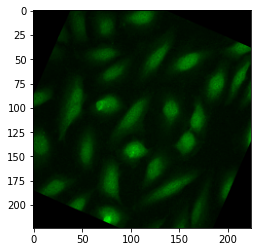

tensor([0, 1, 0, 0])


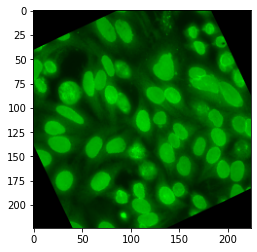

tensor([0, 1, 0, 0])


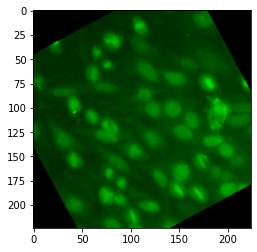

In [20]:
# Clase Dataset Personaliazdo

Custom_transform = transforms.Compose([ 
    transforms.CenterCrop((200, 200)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]) # No hay cambios. i = (i - mean)/std
])

class CustomImageDataset(Dataset):
    def __init__(self, augmented_dataset, names, labels, transform=None):
        self.augmented_dataset = augmented_dataset
        self.names = names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.names[idx][0].split('.')[0]
        image = augmented_dataset.get(image_name)[:] 
        image = torch.tensor(image)  
        label = torch.tensor(self.labels[idx])      

        if self.transform:
            image = self.transform(image)
        
        return image, label

# Creando Dataloader para los conjuntos de entrenamiento y prueba
augmented_dataset = h5py.File(dataset_path, 'r')

Batch_size = 64

train_data = CustomImageDataset(augmented_dataset, x_train, y_train) # transform=Custom_transform
train_dataloader = DataLoader(train_data, batch_size=Batch_size, shuffle=True, num_workers=2)   #-------------------------Cambiar el shuffle-----------------------

val_data = CustomImageDataset(augmented_dataset, x_val, y_val)
val_dataloader = DataLoader(val_data, batch_size=Batch_size, shuffle=True, num_workers=2)       #-------------------------Cambiar el shuffle----------------------- 

test_data = CustomImageDataset(augmented_dataset, x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=Batch_size, shuffle=False, num_workers=2)    #-------------------------Cambiar el shuffle-----------------------

images, labels = next(iter(train_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(val_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(test_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

In [15]:
# Prueba de velocidad del dataloader

start_time = time.time()
i = 0
for images, label in iter(train_dataloader):
  i +=1
  print("Iteracion: ", i)

final_time = time.time() - start_time
print('Tiempo de recorrido del dataloader:', round(final_time/60, 3))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteracion:  1
Iteracion:  2
Iteracion:  3
Iteracion:  4
Iteracion:  5
Iteracion:  6
Iteracion:  7
Iteracion:  8
Iteracion:  9
Iteracion:  10
Iteracion:  11
Iteracion:  12
Iteracion:  13
Iteracion:  14
Iteracion:  15
Iteracion:  16
Iteracion:  17
Iteracion:  18
Iteracion:  19
Iteracion:  20
Iteracion:  21
Iteracion:  22
Iteracion:  23
Iteracion:  24
Iteracion:  25
Iteracion:  26
Iteracion:  27
Iteracion:  28
Iteracion:  29
Iteracion:  30
Iteracion:  31
Iteracion:  32
Iteracion:  33
Iteracion:  34
Iteracion:  35
Iteracion:  36
Iteracion:  37
Iteracion:  38
Iteracion:  39
Iteracion:  40
Iteracion:  41
Iteracion:  42
Iteracion:  43
Iteracion:  44
Iteracion:  45
Iteracion:  46
Iteracion:  47
Iteracion:  48
Iteracion:  49
Iteracion:  50
Iteracion:  51
Iteracion:  52
Iteracion:  53
Iteracion:  54
Iteracion:  55
Iteracion:  56
Iteracion:  57
Iteracion:  58
Iteracion:  59
Iteracion:  60
Iteracion:  61
Iteracion:  62
Iteracion:  63
Iteracion:  64
Iteracion:  65
Iteracion:  66
Iteracion:  67
Iter

In [21]:
def Train_model(model, train_dataloader, val_dataloader, optimizer, criterion, epochs=10):
    model.to(device)

    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        for batch in iter(train_dataloader):
            X, Y = batch
            X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
            optimizer.zero_grad()
            Y_hat = model(X)
            loss = criterion(Y_hat, Y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
            Y_hat[Y_hat > 0.5] = 1
            Y_hat[Y_hat < 1] = 0
            #print(Y)
            #print(Y_hat)
            acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
            train_acc.append(acc)
        
        model.eval()
        val_loss, val_acc = [], []
        with torch.no_grad():
            for batch in iter(val_dataloader):
                X, Y = batch
                X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
                Y_hat = model(X)

                #print("Antes", Y)
                #print("Y_hat Antes", Y_hat)
                
                loss = criterion(Y_hat, Y)
                val_loss.append(loss.item())
                
                Y_hat[Y_hat > 0.5] = 1
                Y_hat[Y_hat < 1] = 0

                #print("Despues", Y_hat)
                acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
                val_acc.append(acc)
        
        #print(train_acc)
        #print(val_acc)
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f} \n")


In [22]:
# Clase para adaptar modelo pre-entrenados

class MyExtendedNet(nn.Module):
    def __init__(self, pretrained_model):
        super(MyExtendedNet, self).__init__()
        self.pretrained = pretrained_model
        self.new_layer = nn.Sequential(nn.Linear(1000, 1000),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(1000, 500),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(500, 100),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(100, 10),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(10, 4),
                                         #nn.Sigmoid()
                                         )     
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.pretrained(x)
        x = self.new_layer(x)
        return x

In [23]:
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Llamando 4 modelos distintos

alexnet = models.alexnet(pretrained=True)
print("AlexNet: ", alexnet)
model = MyExtendedNet(alexnet)

#resnet152 = models.resnet152(pretrained=True)
#print("ResNet152: ", resnet152)
#model = MyExtendedNet(resnet512)

#densenet201 = models.densenet201(pretrained=True)
#print("DenseNet: ", densenet201)
#model = MyExtendedNet(densenet201)

#googlenet = models.googlenet(pretrained=True)
#print("GoogleNet: ", googlenet)
#model = MyExtendedNet(googlenet)


if torch.cuda.is_available():
    model.cuda()
    weights = torch.tensor(weights, device='cuda')
    print(weights.type())

epochs = 10
loss_fn = nn.CrossEntropyLoss(weight = weights)
#loss_fn = nn.BCELoss(weight = weights)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

start_time = time.time()
Train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, epochs)
final_time = time.time() - start_time
print('Tiempo de entrenamiento y validacion:', round(final_time/60, 3))

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet:  AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1/10 loss 0.25257 val_loss 0.25203 acc 0.00905 val_acc 0.00375 

Epoch 2/10 loss 0.24496 val_loss 0.22077 acc 0.00637 val_acc 0.00813 

Epoch 3/10 loss 0.24002 val_loss 0.22842 acc 0.00397 val_acc 0.00598 

Epoch 4/10 loss 0.22531 val_loss 0.20623 acc 0.00219 val_acc 0.00063 

Epoch 5/10 loss 0.21877 val_loss 0.20832 acc 0.00069 val_acc 0.00063 

Epoch 6/10 loss 0.21307 val_loss 0.20277 acc 0.00116 val_acc 0.00250 

Epoch 7/10 loss 0.21043 val_loss 0.20096 acc 0.00178 val_acc 0.00187 

Epoch 8/10 loss 0.21436 val_loss 0.20414 acc 0.00192 val_acc 0.00313 

Epoch 9/10 loss 0.20673 val_loss 0.20054 acc 0.00260 val_acc 0.00500 

Epoch 10/10 loss 0.20833 val_loss 0.19482 acc 0.00288 val_acc 0.00674 

Tiempo de entrenamiento y validacion: 8.628
